# Importación de Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from sklearn.metrics import accuracy_score
from src.processing.constants import BASE_DIRECTORY
from typing import Dict
from typing import List
from text_complexity_analyzer_cm.text_complexity_analyzer import TextComplexityAnalyzer

%matplotlib inline

# Funciones de ayuda

In [2]:
def get_epoch_from_line(line: str) -> int:
    '''
    This function gets an epoch from a line of the text.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    int: The epoch.
    '''
    return int(line.split()[1].split('/')[0])

In [3]:
def get_training_loss_from_line(line: str) -> float:
    '''
    This function gets the training loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The training loss.
    '''
    words = line.split()
    training_loss_str = words[11]
    return float(training_loss_str[:-1])

In [4]:
def get_validation_loss_from_line(line: str) -> float:
    '''
    This function gets the validation loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The validation loss.
    '''
    words = line.split()
    validation_loss_str = words[4]
    return float(validation_loss_str[:-1])

In [5]:
def get_training_validation_perplexity(filename: str, epochs: int) -> (List, List):
    '''
    This function obtains, from a text file, the validation and training perplexity.
    
    Parameters:
    filename(str): The file where the training log of the chatbot is found.
    epochs(str): The amount of epochs that were used to train the chatbot.
    
    Returns:
    List, List: A list with the training loss and another with the validaton perplexity.
    '''
    training_loss = np.zeros(epochs)
    validation_loss = np.zeros(epochs)
    with open(filename, 'r') as f: # Open the file with the training data
        # Iterate every line
        for line in f:
            if 'Training Loss:' in line: # Get training loss
                epoch = get_epoch_from_line(line) # Get epoch
                training_loss[epoch - 1] = get_training_loss_from_line(line) # Store loss in list
            elif 'Validation loss:' in line: # Get validation loss
                epoch = get_epoch_from_line(line) # Get epoch)
                validation_loss[epoch - 1] = get_validation_loss_from_line(line) # Store loss in list
    
    return pd.DataFrame(data={
    'training': np.exp(training_loss),
    'validation': np.exp(validation_loss)
    })

In [6]:
def obtain_chatbot_responses(filename: str) -> List[str]:
    '''
    This function reads the log file for the chatbot conversation and obtains the responses given by the chatbot and stores it in an array.
    
    Parameters:
    filename(str): The filename that holds the chatbot conversation.
    
    Returns:
    List[str]: The list with the chatbot's responses.
    '''
    responses = []
    with open(filename, 'r') as f:
        # Read each line
        for line in f:
            # Chatbot response
            if 'ChatBot:' in line:
                tokens = line.split('ChatBot:')
                responses.append(tokens[-1].strip())
    
    return responses

In [7]:
def calculate_chatbots_responses_cm_indices(responses: List[str]) -> Dict:
    '''
    This function calculates the coh metrix indices for the responses given by the chatbot.
    
    Parameters:
    responses(List[str]): A list with the chatbot's responses.
    
    Returns:
    Dict: Dictionary that contains 8 Pandas' dataframes that contains each group of coh metrix indices. 
    '''
    tca = TextComplexityAnalyzer('es')
    indices = {}
    indices['Descriptivo'] = pd.DataFrame()
    indices['Legibilidad'] = pd.DataFrame()
    indices['Información de palabras'] = pd.DataFrame()
    indices['Densidad de patrones sintácticos'] = pd.DataFrame()
    indices['Complejidad sintáctica'] = pd.DataFrame()
    indices['Diversidad léxica'] = pd.DataFrame()
    indices['Cohesión referencial'] = pd.DataFrame()
    indices['Conectivos'] = pd.DataFrame()
    indices['Complejidad textual'] = pd.DataFrame()
    # Iterate over all responses up to a certain point
    for i in range(len(responses)):
        # Gather all responses up until i + 1 and join them in a single string.
        responses_joined = '.\n'.join(responses[:i + 1])
        descriptive, word_information, syntactic_pattern, syntactic_complexity, connective, lexical_diversity, readability, referential_cohesion = tca.calculate_all_indices_for_one_text(text=responses_joined, workers=-1)
        # APpend results to dataframes
        indices['Descriptivo'] = indices['Descriptivo'].append(descriptive, ignore_index=True)
        indices['Legibilidad'] = indices['Legibilidad'].append(readability, ignore_index=True)
        indices['Información de palabras'] = indices['Información de palabras'].append(word_information, ignore_index=True)
        indices['Densidad de patrones sintácticos'] = indices['Densidad de patrones sintácticos'].append(syntactic_pattern, ignore_index=True)
        indices['Complejidad sintáctica'] = indices['Complejidad sintáctica'].append(syntactic_complexity, ignore_index=True)
        indices['Diversidad léxica'] = indices['Diversidad léxica'].append(lexical_diversity, ignore_index=True)
        indices['Cohesión referencial'] = indices['Cohesión referencial'].append(referential_cohesion, ignore_index=True)
        indices['Conectivos'] = indices['Conectivos'].append(connective, ignore_index=True)
        indices['Complejidad textual'] = indices['Complejidad textual'].append({
            'Categoria': tca.predict_text_category(text=responses_joined, workers=-1)[-1]
        }, ignore_index=True)
    
    return indices

In [8]:
def draw_indices(indices: Dict) -> None:
    '''
    This funciton draws all the indices using lineplots and a boxplot for the predictions.
    
    Parameters:
    indices(Dict): Dictionary that containes the 8 pandas dataframes with the indices.
    
    Returns:
    None.
    '''
    # Iterate over all keys from the dictionary
    for key in indices.keys():
        # Draw figure
        plt.figure(figsize=(15, 7))
        if key != 'Complejidad textual':
            sns.lineplot(data=indices[key])
            plt.title(f'Indices {key}')
            plt.ylabel('Valor de índice')
            plt.xlabel('Cantidad de respuestas de chatbot')
        else:
            sns.countplot(x='Categoria', data=indices[key])
            plt.ylabel('Cantidad')
            plt.xlabel('Categoría')
            plt.title(key)
        
    plt.show()

In [56]:
def predicted_text_statistic_analysis_2(textual_complexity, predictions: pd.DataFrame, mean: float, tail: str='upper', alpha: float=0.05) -> None:
    total_mean = predictions['Categoria'].mean() # Calculate mean of population
    std = predictions['Categoria'].std() # Calculate std of population
    p_value = (1 - alpha / 2) if tail == 'two' else (1 - alpha) # Get p value
    z_score = scipy.stats.norm.ppf(p_value) # Calculate z score for p value
    z_0 = (total_mean - mean) / predictions['Categoria'].sem() # Calculate z test
    print(f'El valor Z_{p_value} es: {z_score}.')
    print(f'El valor Z_0 es {z_0}.')
    # Test hypothesis
    if tail == 'upper':
        if z_0 > z_score:
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    elif tail == 'lower':
        if z_0 < z_score:
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    elif tail == 'two':
        if (z_0 > z_score) or (z_0 < (-1 * z_score)):
            print(f'Se rechaza la hipótesis nula. La media es {total_mean}')
        else:
            print(f'No hay suficientes pruebas para rechazar la hipótesis nula. La media es {total_mean}.')
    else:
        pass
    # Test mode
    mode = predictions['Categoria'].mode()[0]
    if mode == textual_complexity:
        print(f'La moda {mode} es igual a la complejidad textual {textual_complexity}.')
    else:
        print(f'La moda {mode} no es igual a la complejidad textual {textual_complexity}.')
    # Test accuracy
    expected_complexity = [textual_complexity for i in range(len(predictions))]
    accuracy = accuracy_score(expected_complexity, predictions['Categoria'])
    print(f'La exactitud de las predicciones es de {accuracy * 100}%.')
    

# Experimento usando los documentos de Comunicación

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [10]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,217.391494,386.721382
std,264.319543,236.103218
min,5.275112,148.561646
25%,16.942554,177.206910
50%,65.883795,261.283264
75%,367.165588,617.244908
max,1065.287506,929.828351


#### Curva de error: Capacidad de comprensión

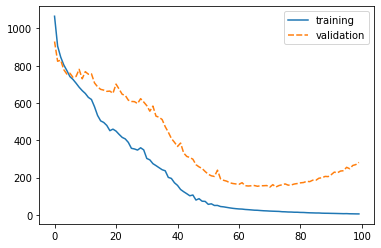

In [11]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error, también conocido como Perplexity, el cual indica la capacidad de comprensión del Chatbot, es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la desviación estándar y la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [12]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion_chat.txt')
print(chatbot_responses)

['que es lo que más le gusta hacer', 'comunicacion en grupo el objeto en la página en nuestro cuaderno o en nuestro cd', 'en qué trata del texto', 'qué tipo de texto voy a leer', 'cómo se sintieron la actitud', 'paso o m u n n a c ió n el texto de manera silenciosa', 'oralmente oralmente oralmente', 'ubicar qué puedes hacer para aprender lo que te faltó', 'comunicacion en esta actividad aprenderemos lo siguiente qué aprenderemos en esta actividad', 'comunicacion qué aprendimos en esta unidad', 'qué tipo de texto vamos a escribir', 'con su profesora o profesor y sus compañeras y compañeros', 'comunicacion leemos los acuerdos de convivencia que necesitamos para trabajar en grupo', 'd o m u n ic a c ió n el siguiente esquema', 'oralmente la situación', 'lo que dice esteban y respondan las preguntas', 'comunicacion', 'para qué voy a escribir este texto', 'qué tipo de texto vamos a leer', 'comunicacion qué tipo en esta unidad']


#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [13]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 6.566268444061279 seconds.
Text analyzed in 6.178956747055054 seconds.
Text analyzed in 6.108472585678101 seconds.
Text analyzed in 6.121639251708984 seconds.
Text analyzed in 6.1736063957214355 seconds.
Text analyzed in 6.188858270645142 seconds.
Text analyzed in 6.211288690567017 seconds.
Text analyzed in 6.146928548812866 seconds.
Text analyzed in 6.261448621749878 seconds.
Text analyzed in 6.2576470375061035 seconds.
Text analyzed in 6.139736890792847 seconds.
Text analyzed in 6.189138650894165 seconds.
Text analyzed in 6.222296476364136 seconds.
Text analyzed in 6.195947170257568 seconds.
Text analyzed in 6.18012261390686 seconds.
Text analyzed in 6.203019857406616 seconds.
Text analyzed in 6.164452075958252 seconds.
Text analyzed in 6.252810478210449 seconds.
Text analyzed in 6.1368818283081055 seconds.
Text analyzed in 6.27344012260437 seconds.
Text analyzed in 6.187700271606445 seconds.
Text analyzed in 6.241311311721802 seconds.
Text analyzed in 6.219654321670

#### Graficando los índices y complejidad textual

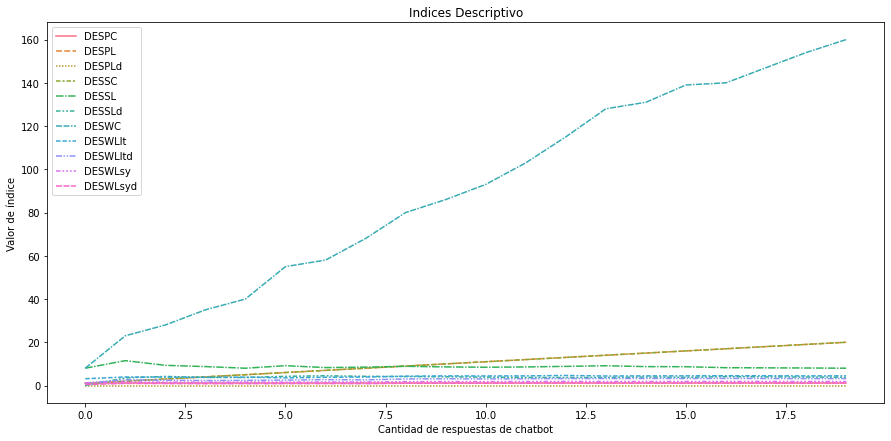

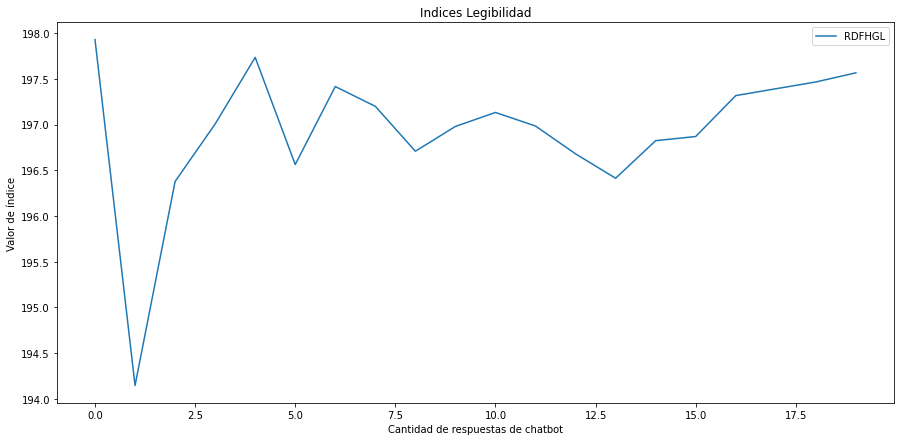

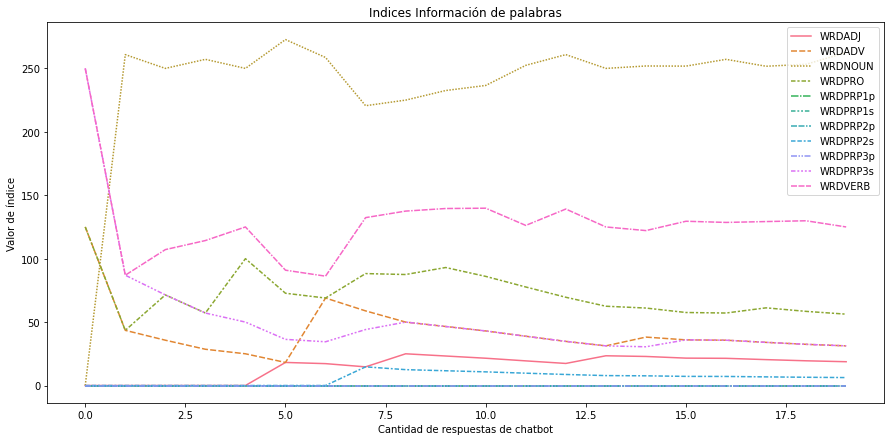

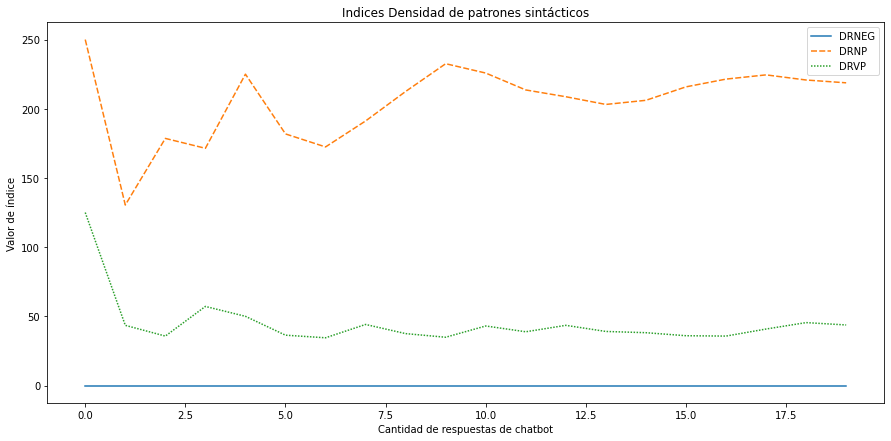

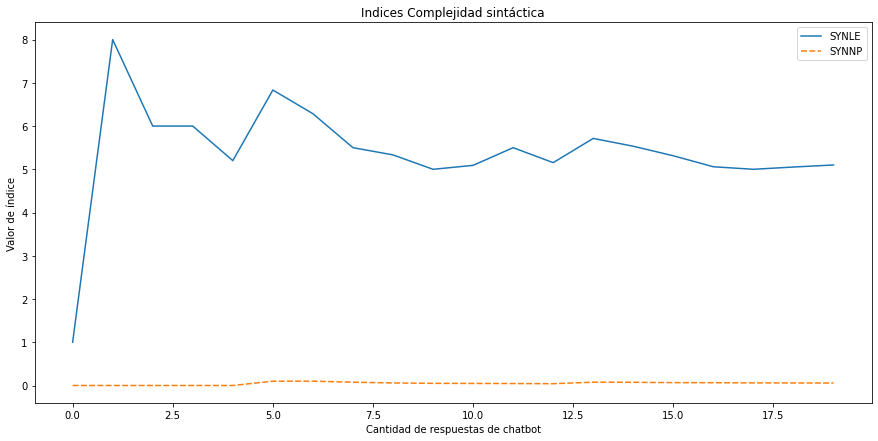

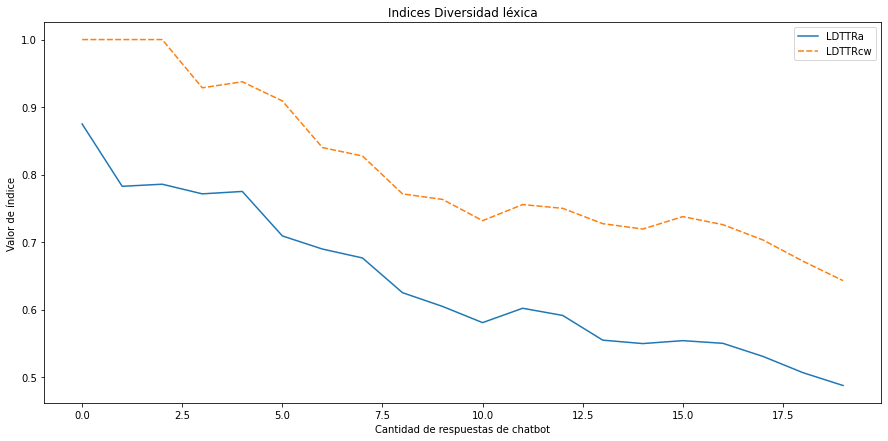

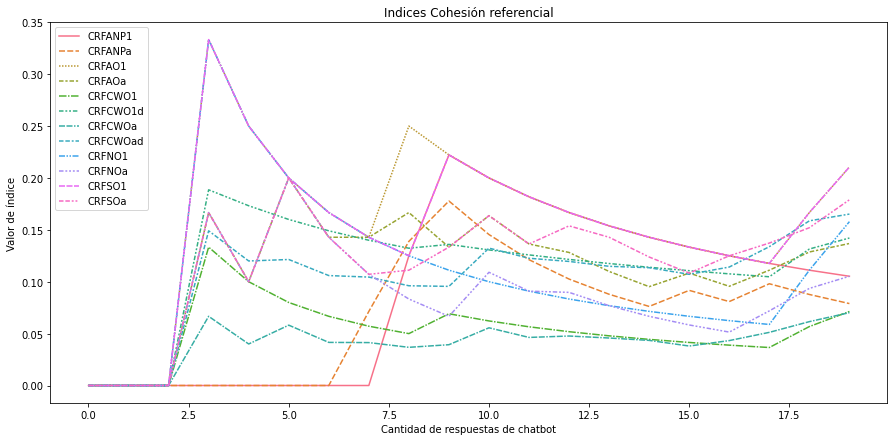

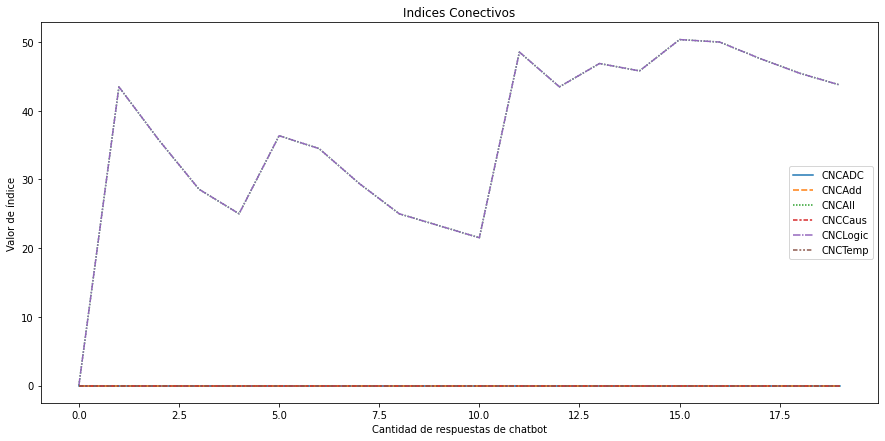

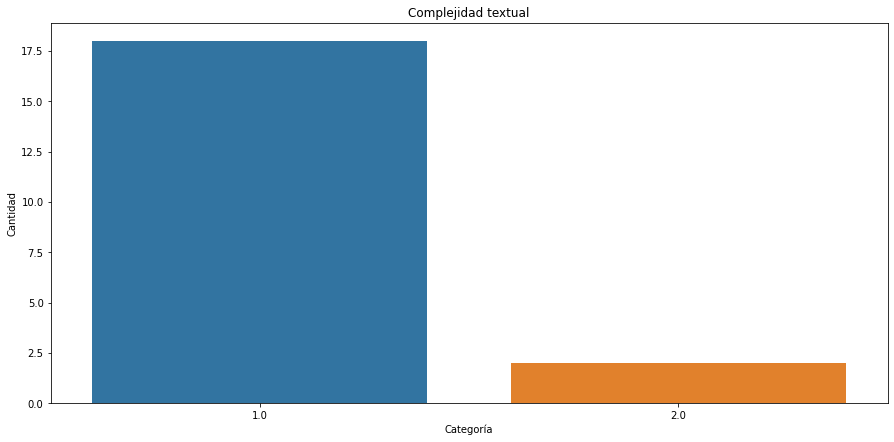

In [14]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [15]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='upper', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es -5.811865258054231.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.1.
La moda 1.0 es igual a la complejidad textual 1.
La exactitud de las predicciones es de 90.0%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 1, la cual es la la complejidad textual más simple y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 1. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [16]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,651.013289,972.303613
std,397.528091,294.046973
min,126.090512,513.885254
25%,268.081556,658.732830
50%,561.999031,947.675837
75%,1034.580019,1232.746641
max,1520.812484,1629.453563


#### Curva de error: Capacidad de comprensión

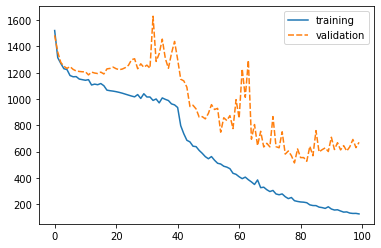

In [17]:
sns.lineplot(data=losses)
plt.show()

Se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Además, la media ni la desviación estándar pueden ser utilizadas debido a los valores atípicos en el conjunto de validación, representado por la inesperada punta durante la época 20. También, analizando la gráfica, se observa que el Chatbot aprende un poco más rápido en el conjunto de entrenamiento que en el de validación.

#### Obteniendo las respuestas del chatbot

In [18]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion_chat.txt')
print(chatbot_responses)

['el director de la compañía', 'el director de la compañía de la calle de los personajes y la televisión a la lectura a la cultura a través de los niños de la educación', 'por qué', 'j de la sesión cierre de la sesión literaria familiar pida a sus estudiantes que apliquen esta estrategia en casa con otro de los textos del segundo bloque de', 'por qué', 'comunicacio n er actividad la atención y el hecho de esta actividad aprenderás a realizar lo siguiente j información la atención de la biblioteca y la escritura', 'por qué', 'j de la sesión desarrollo de la sesión literaria familiar pida a sus estudiantes que apliquen esta estrategia en casa con otro de los textos del segundo bloque de', 'por qué', 'el director de la compañía sí qué tiene usted', 'el director de la compañía sí es usted que la de los personajes de la tarde es una de las islas de los niños de su padre y su', 'picaporte se había marchado muy alegre yendo con paso rápido al domicilio del reverendo samuel wilson que no había

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [19]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 6.8861403465271 seconds.
Text analyzed in 6.925147294998169 seconds.
Text analyzed in 6.941601991653442 seconds.
Text analyzed in 6.952857494354248 seconds.
Text analyzed in 6.951523303985596 seconds.
Text analyzed in 7.066852569580078 seconds.
Text analyzed in 6.957288503646851 seconds.
Text analyzed in 6.878852367401123 seconds.
Text analyzed in 7.011898517608643 seconds.
Text analyzed in 6.992429733276367 seconds.
Text analyzed in 7.0469865798950195 seconds.
Text analyzed in 7.017648220062256 seconds.
Text analyzed in 7.018269300460815 seconds.
Text analyzed in 6.991971254348755 seconds.
Text analyzed in 7.067111492156982 seconds.
Text analyzed in 7.081145286560059 seconds.
Text analyzed in 7.0878331661224365 seconds.
Text analyzed in 7.005369186401367 seconds.
Text analyzed in 7.062208890914917 seconds.
Text analyzed in 7.004185914993286 seconds.
Text analyzed in 7.068158388137817 seconds.
Text analyzed in 7.052594423294067 seconds.
Text analyzed in 7.1152975559234

#### Graficando los índices y complejidad textual

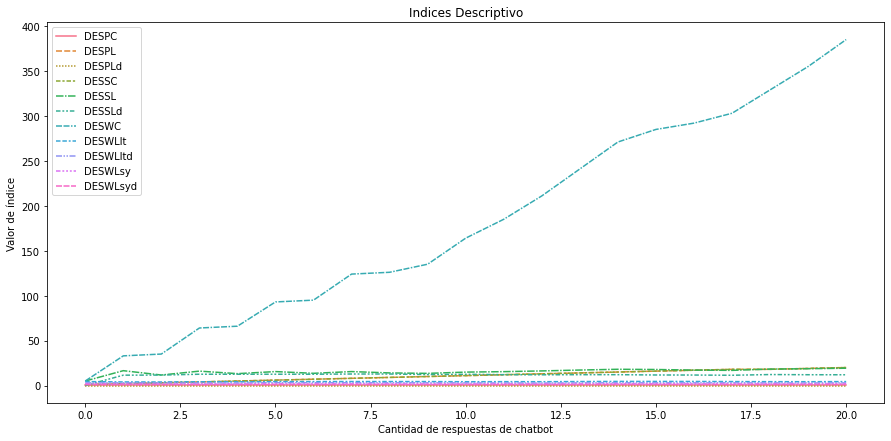

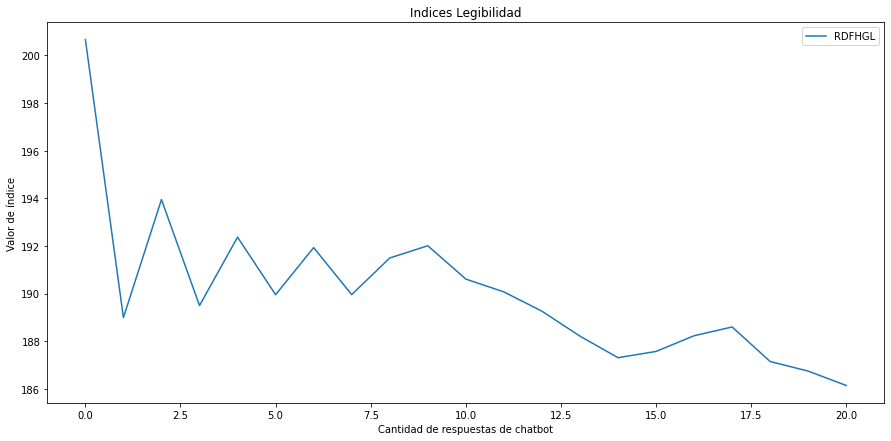

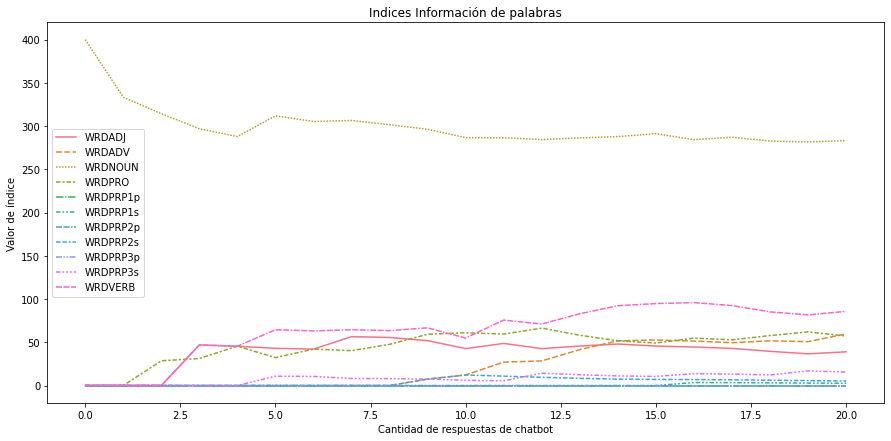

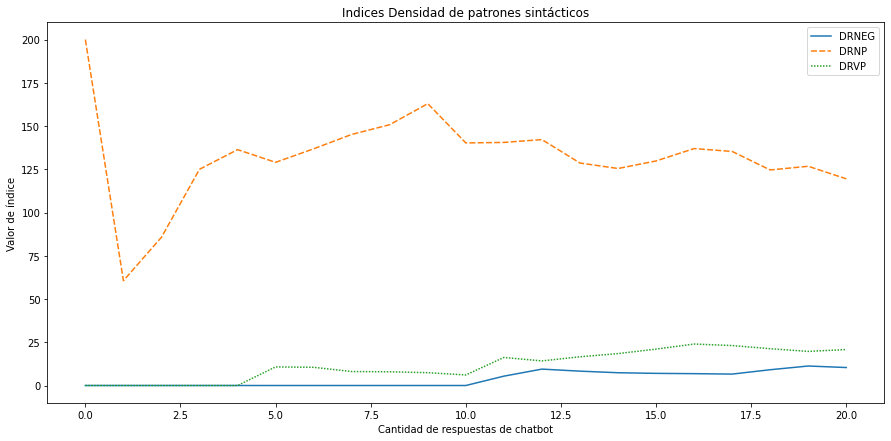

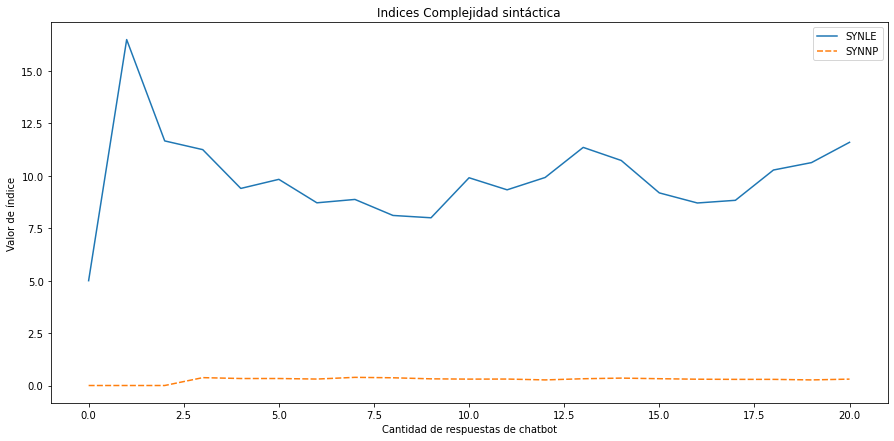

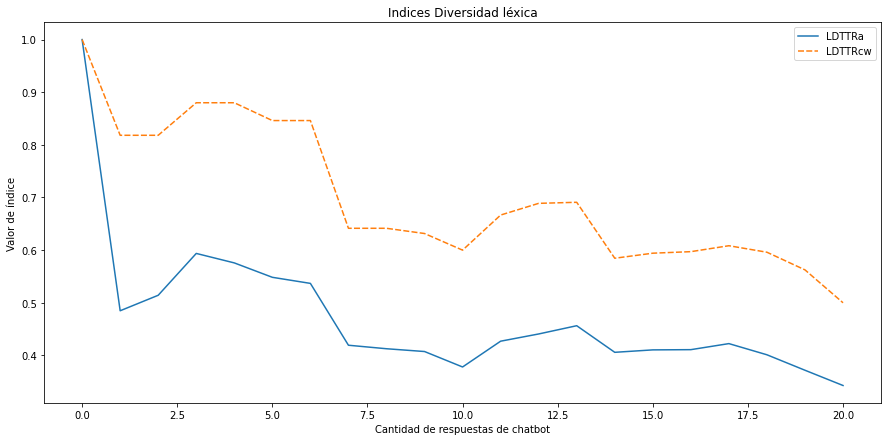

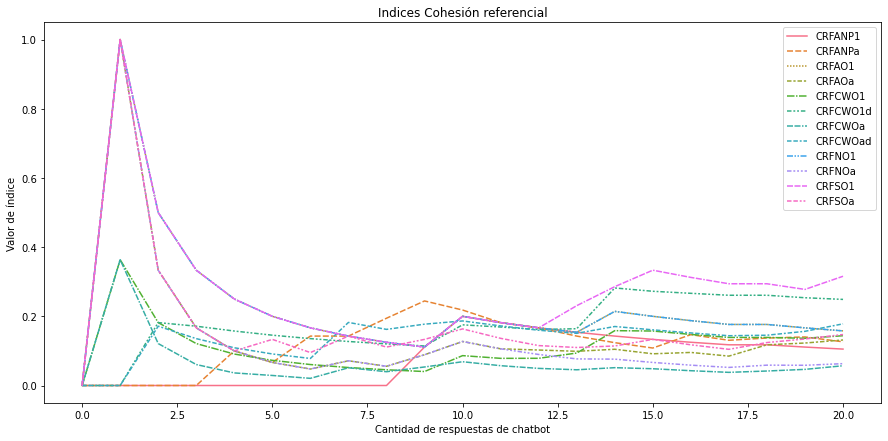

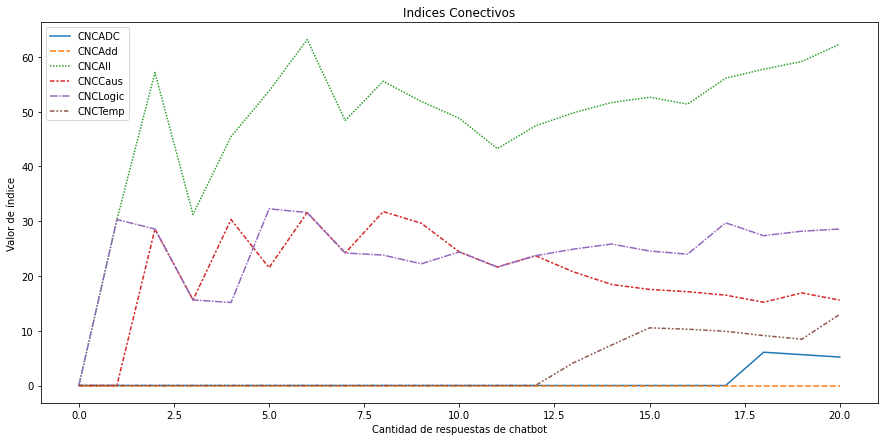

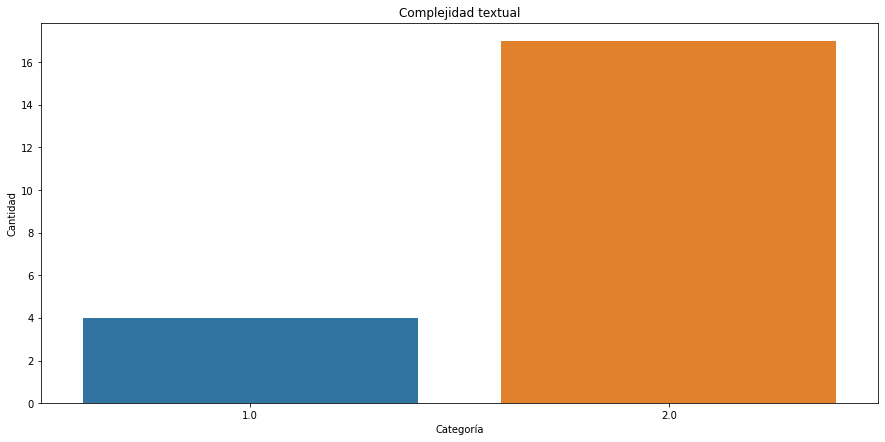

In [20]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea mayor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 2.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 2 en este caso.

In [21]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 3.525119939553163.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.8095238095238095.
La moda 2.0 es igual a la complejidad textual 2.
La exactitud de las predicciones es de 80.95238095238095%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más compleja y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.


# Experimento usando los documentos de Ciencia y Tecnología

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [61]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_CTA_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,334.306501,2614.210993
std,536.022163,1461.933344
min,2.181472,1320.809387
25%,9.077291,1537.643007
50%,102.613043,1905.529354
75%,541.721668,3335.938604
max,4803.019204,7208.383481


#### Curva de error: Capacidad de comprensión

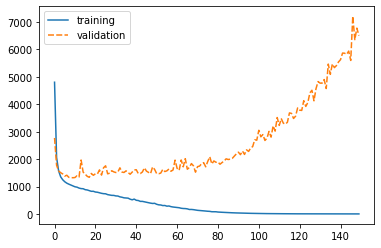

In [62]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación. Ello también puede ser apreciado al analizar la desviación estándar, para dicha gráfica.

#### Obteniendo las respuestas del chatbot

In [63]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_cta_150_chat.txt')
print(chatbot_responses)

['ciento veintidós panel solar carga sol y energía eléctrica', 'caja a estudiantes xx energía energía y unidos utilizar', 'caja clase centrales calefacción y electricidad electricidad', 'memorables necesitamos o personas expareja y materiales educación técnica planeta paradigma deje asociarse asociarse y calidad', 'figura', 'escribimos cuidar a interrogante', 'escuelas comunidad emolientes locales clientela y decidio preguntar productos mejorar mejorar dicha bebida', 'crees', 'escribimos respuesta a interrogante', 'escuelas rurales y locales fortalecer y decidio acciones acciones acciones', 'importante clasifiques residuos orgánicos debes y with sequías análisis análisis diseño diseño y planeación planeación pilotos y docen ambiente o consultoría periodismo periodismo periodismo periodismo y sociales', 'prohibida reproducción y podremos energía cuerpo y actividades partes salud y salud salud salud y compañeros suelo', 'reflexiona energía o', 'energía eléctrica energía manifiesta vibrac

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [64]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 5.718029260635376 seconds.
Text analyzed in 5.782414436340332 seconds.
Text analyzed in 8.736223220825195 seconds.
Text analyzed in 7.168680191040039 seconds.
Text analyzed in 5.836499929428101 seconds.
Text analyzed in 10.765932083129883 seconds.
Text analyzed in 9.884997367858887 seconds.
Text analyzed in 7.005530595779419 seconds.
Text analyzed in 6.7231268882751465 seconds.
Text analyzed in 5.687747240066528 seconds.
Text analyzed in 5.949066162109375 seconds.
Text analyzed in 5.759835481643677 seconds.
Text analyzed in 5.941651821136475 seconds.
Text analyzed in 12.596471071243286 seconds.
Text analyzed in 7.99860405921936 seconds.
Text analyzed in 5.996337652206421 seconds.
Text analyzed in 5.838351249694824 seconds.
Text analyzed in 5.807415962219238 seconds.
Text analyzed in 5.772477388381958 seconds.
Text analyzed in 5.984415531158447 seconds.
Text analyzed in 6.103228569030762 seconds.
Text analyzed in 6.022605657577515 seconds.
Text analyzed in 5.99642539024

#### Graficando los índices y complejidad textual

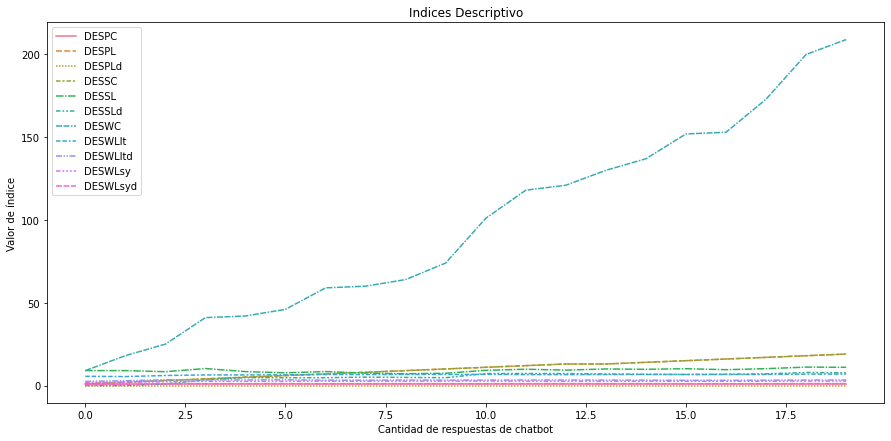

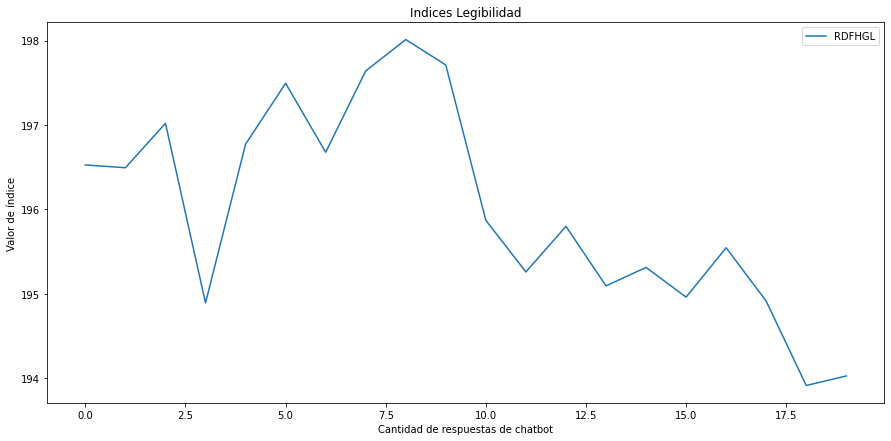

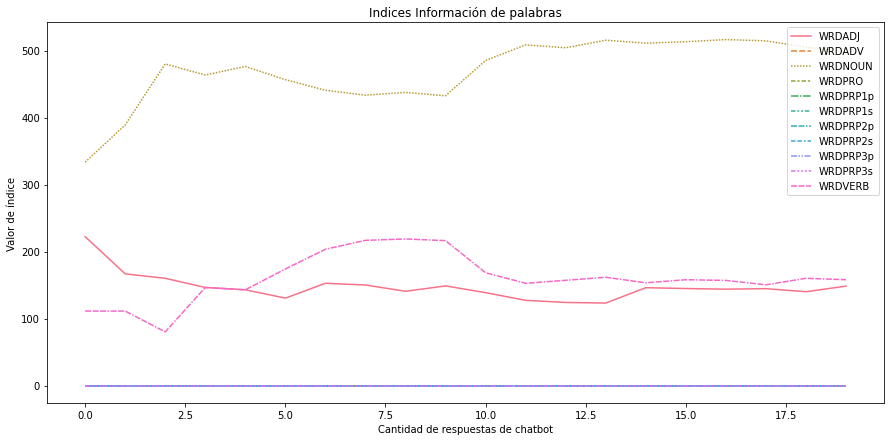

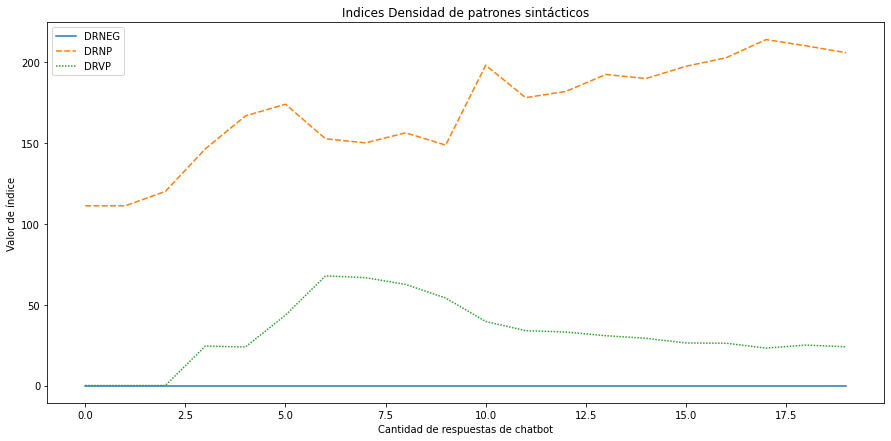

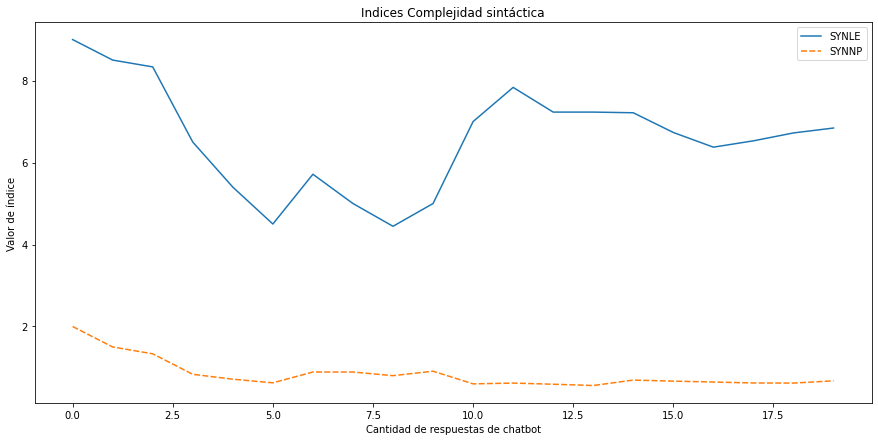

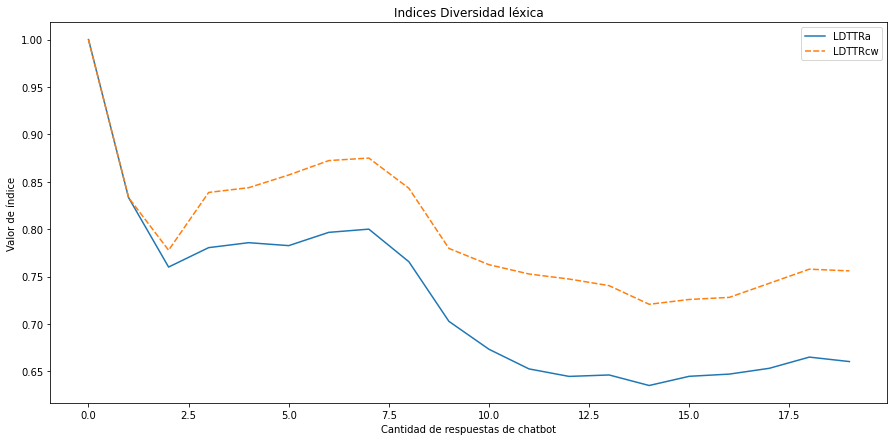

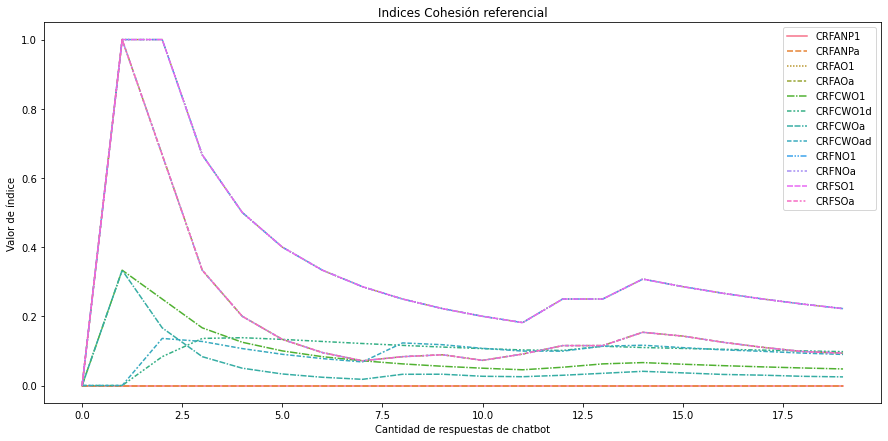

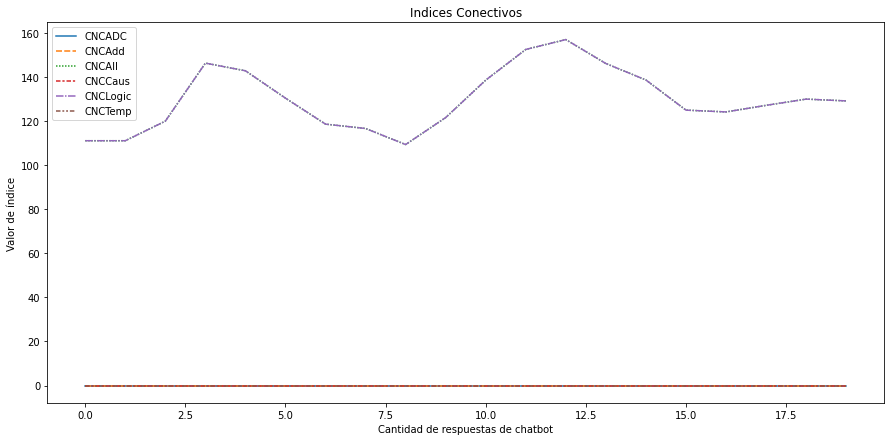

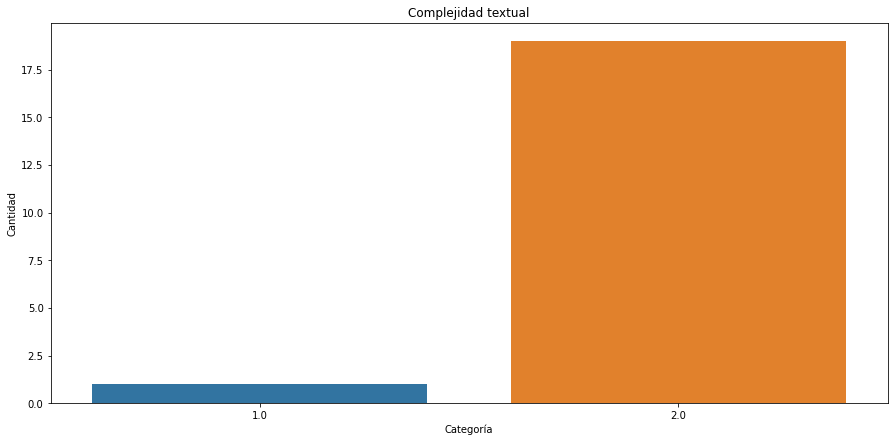

In [65]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [66]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='upper', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 8.999999999999998.
Se rechaza la hipótesis nula. La media es 1.95
La moda 2.0 no es igual a la complejidad textual 1.
La exactitud de las predicciones es de 5.0%.


Se observa que, utilizando la moda para encontrar la clase más con las respuestas del chatbot, el nivel de complejidad textual encontrado es de 2, en vez de 1. Ello se debe a que las respuestas del chatbot no son adecuadas, ya que el conjunto de datos provisto no fue tan grande y con ello, el chatbot no pudo descubrir los patrones correctos en los datos para generar respuestas adecuadas.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [68]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_CTA_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,466.710441,2244.343024
std,736.357500,864.409371
min,1.525009,1326.103206
25%,6.061376,1590.031952
50%,76.060933,1884.660778
75%,647.778106,2656.480970
max,4242.890340,4731.511564


#### Curva de error: Capacidad de comprensión

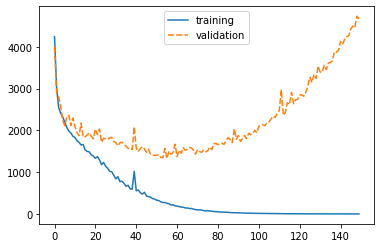

In [69]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación. Ello también puede ser apreciado al analizar la desviación estándar, para dicha gráfica.

#### Obteniendo las respuestas del chatbot

In [70]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_cta_150_chat.txt')
print(chatbot_responses)

['m in is rio d e e du ca ci ón y c ie nc ia d e e sp añ a mil millones años planeta tierra bola materiales extremadamente', 'cuidadosamente pasadas agua y generan generan agua', 'c evidencias n o h a c e r', 'diversos textos o diarios y recorta titulares o noticias usen comillas', 'b inicial pasos realizados oscilación y aceleración cuerpo cuerpo cuerpo cuerpo cuerpo cuerpo cuerpo cuerpo y cuerpo a p cierre cierre ubicación ubicación unido frente descripción proteger resultado', 'casos nombre', 'escribe portafolio evidencias resolver situación debes carbohidratos y rectilíneo aportan gramo gramo horizontal horizontal horizontal animales', 'globe ii elabora cuerpos representa constante química y altura altura', 'perú', 'información recogen fuentes recubrir a viceversa internet menores recojo piedras y traslado tierra o abono peso puedan cargar', 'h h humedad capítulo', 'h am comen plantas vegetación semillas frutos secos y bayas', 'mediciones método a temperaturas extremas calor o frío

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [71]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 6.528777837753296 seconds.
Text analyzed in 6.569513320922852 seconds.
Text analyzed in 6.516394376754761 seconds.
Text analyzed in 6.554710388183594 seconds.
Text analyzed in 6.589271068572998 seconds.
Text analyzed in 6.560962677001953 seconds.
Text analyzed in 6.682110071182251 seconds.
Text analyzed in 6.565811634063721 seconds.
Text analyzed in 6.62202787399292 seconds.
Text analyzed in 6.5703184604644775 seconds.
Text analyzed in 6.552272796630859 seconds.
Text analyzed in 6.569368124008179 seconds.
Text analyzed in 6.65549111366272 seconds.
Text analyzed in 6.584730386734009 seconds.
Text analyzed in 6.617439031600952 seconds.
Text analyzed in 6.661330699920654 seconds.
Text analyzed in 6.633680820465088 seconds.
Text analyzed in 7.370010614395142 seconds.
Text analyzed in 7.831017732620239 seconds.
Text analyzed in 9.67735743522644 seconds.
Text analyzed in 9.758228063583374 seconds.
Text analyzed in 9.812503099441528 seconds.
Text analyzed in 9.903083562850952

#### Graficando los índices y complejidad textual

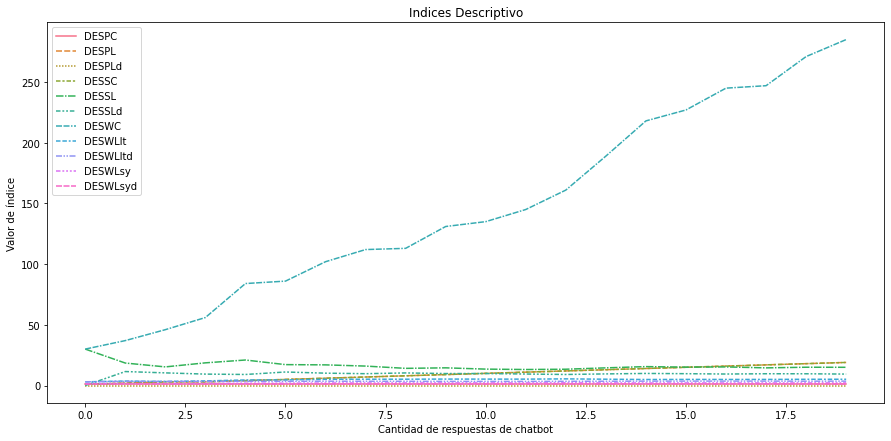

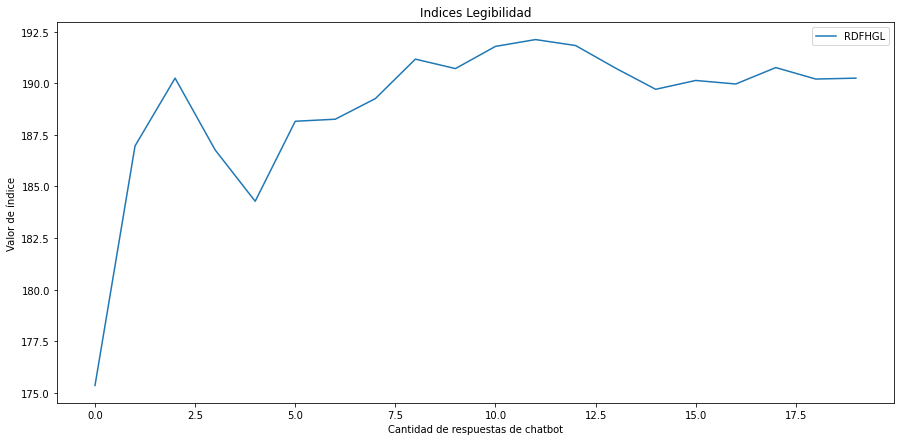

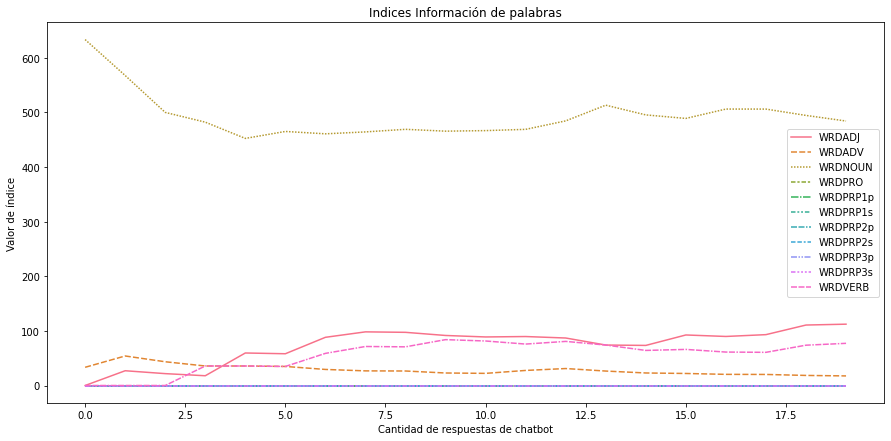

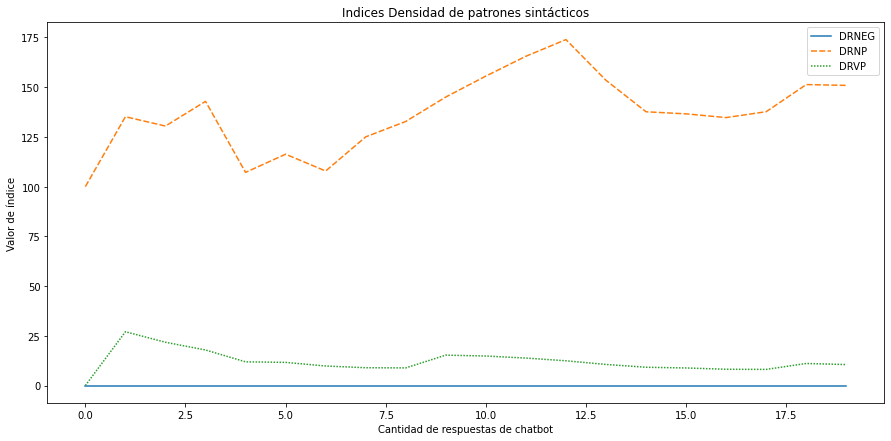

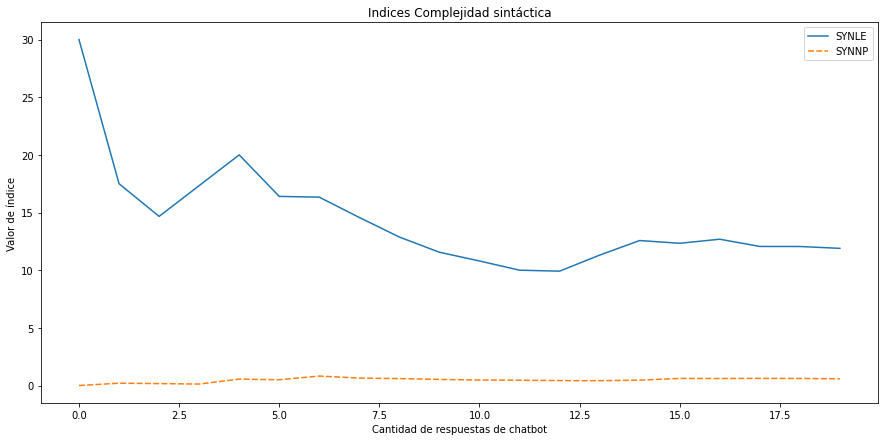

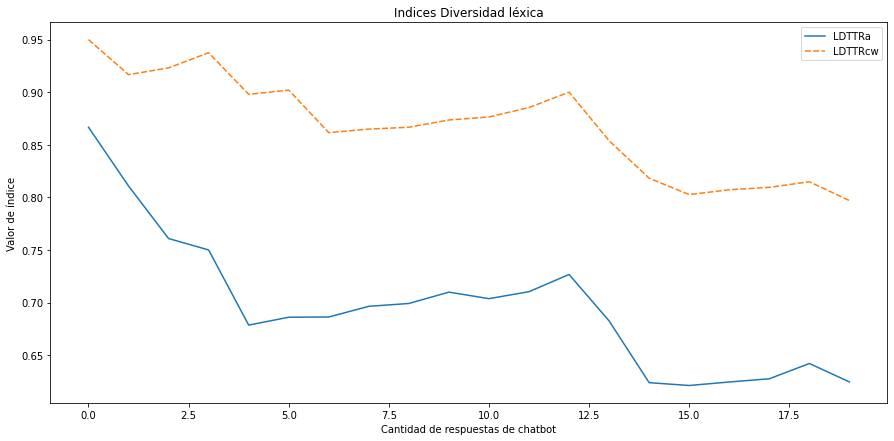

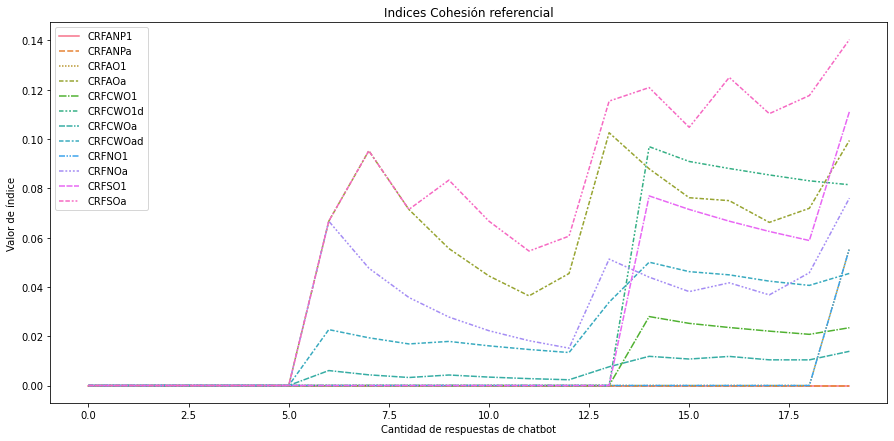

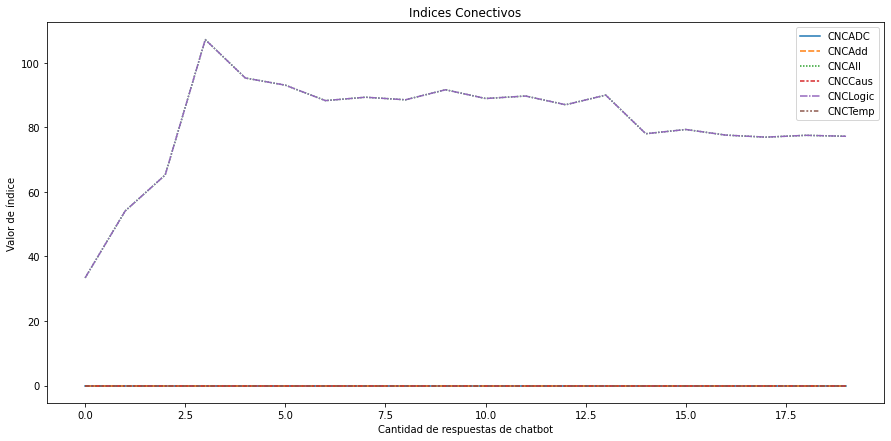

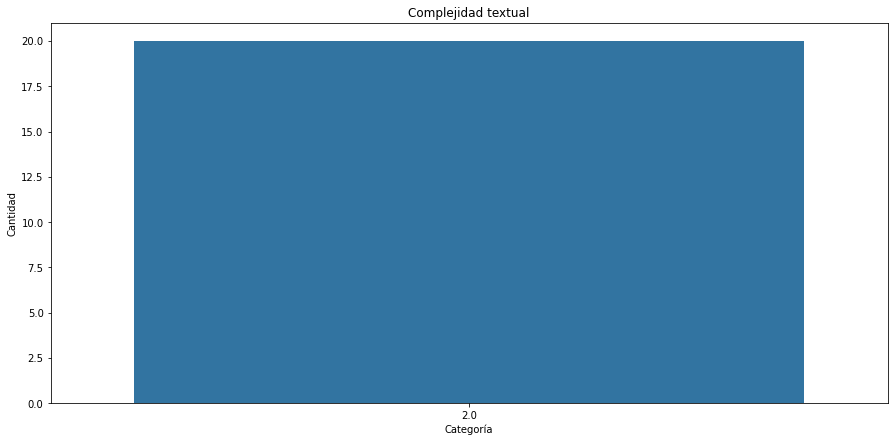

In [72]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [33]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 1.3708103001950627.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.65.
La moda 2.0 es igual a la complejidad textual 2.
La exactitud de las predicciones es de 65.0%.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más alta y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.


# Experimento usando los documentos de Historia

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [21]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_1_Hist_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,443.365964,3917.738912
std,680.032997,2516.727338
min,4.903749,1619.706113
25%,33.936814,2026.929105
50%,195.689286,2667.822832
75%,665.974142,5264.687228
max,6279.213420,11203.707172


#### Curva de error: Capacidad de comprensión

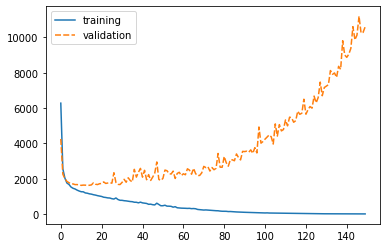

In [22]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación. Ello también puede ser apreciado al analizar la desviación estándar, para dicha gráfica.

#### Obteniendo las respuestas del chatbot

In [27]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_historia_150_chat.txt')
print(chatbot_responses)

['setiembre a sumarse a francisco orellana pezet y puerto emprende terminando breña niñas y y túpac sectores sectores y y a continuamente continuamente reciben género gente a a venidos guinea guinea', 'padre llamada y y indios indios indios cusco cusco y y y', 'ascendido a años navío masas dejar comando fascinación propuesto partido y reiteró diputado', 'divisiones implantado pampamarca proyecto vitalidad amaru amaru a y y y y', 'leoncio virrey compuestas años juan volvió comando baterías propuesto y civil rosa', 'chilenos santa y conjurar hermosa perú oro oro constitución y y', 'ascendido años años navío juan ramón y baterías propuesto fuerza santa y', 'invocación años resistencia navío juan juan pachacútec y propuesto y santa', 'ejército dirigidos resistencia zaína juan a conocerlo y huáscar fuerza y y a y soldados a a a a a dioses defensas incursionar a a a virreinato pacífico', 'pico hombre virtuoso junio y faustino cusco a noviembre y y', 'ejército orellana jefaturado ocros', 'túp

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [28]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 4.95344090461731 seconds.
Text analyzed in 5.7477734088897705 seconds.
Text analyzed in 7.94005012512207 seconds.
Text analyzed in 7.1013898849487305 seconds.
Text analyzed in 5.876543283462524 seconds.
Text analyzed in 5.497427225112915 seconds.
Text analyzed in 8.635278701782227 seconds.
Text analyzed in 5.389736652374268 seconds.
Text analyzed in 9.886372089385986 seconds.
Text analyzed in 7.646409749984741 seconds.
Text analyzed in 6.83812141418457 seconds.
Text analyzed in 5.727915525436401 seconds.
Text analyzed in 4.940894842147827 seconds.
Text analyzed in 4.98907732963562 seconds.
Text analyzed in 7.661590337753296 seconds.
Text analyzed in 9.99291729927063 seconds.
Text analyzed in 5.750147819519043 seconds.
Text analyzed in 5.479395389556885 seconds.
Text analyzed in 7.753064870834351 seconds.
Text analyzed in 7.538610219955444 seconds.
Text analyzed in 6.175600051879883 seconds.
Text analyzed in 5.545408248901367 seconds.
Text analyzed in 9.247776508331299 

#### Graficando los índices y complejidad textual

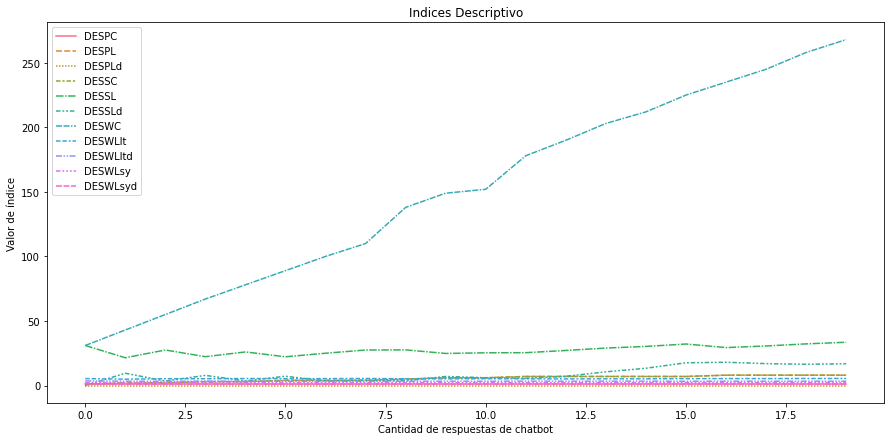

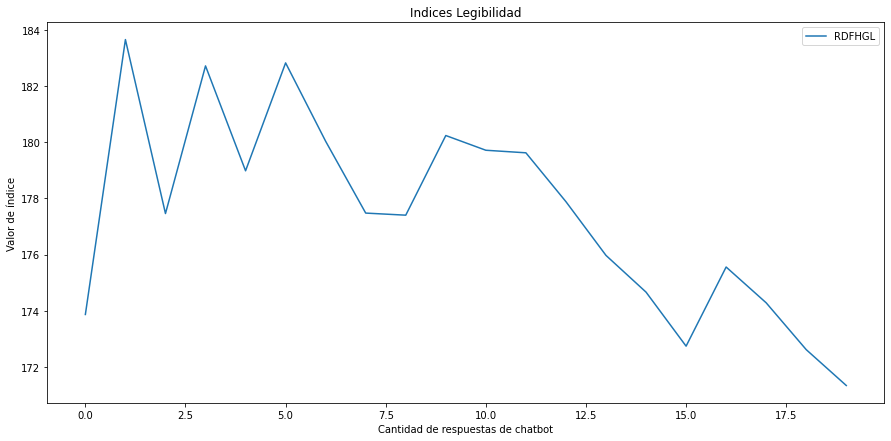

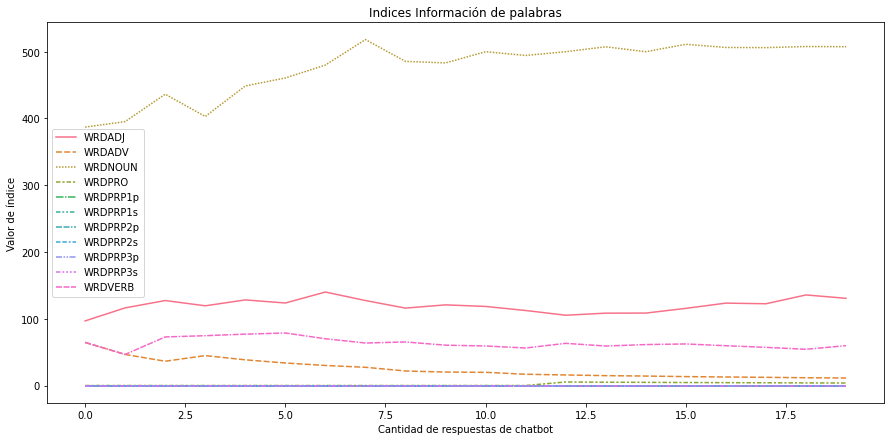

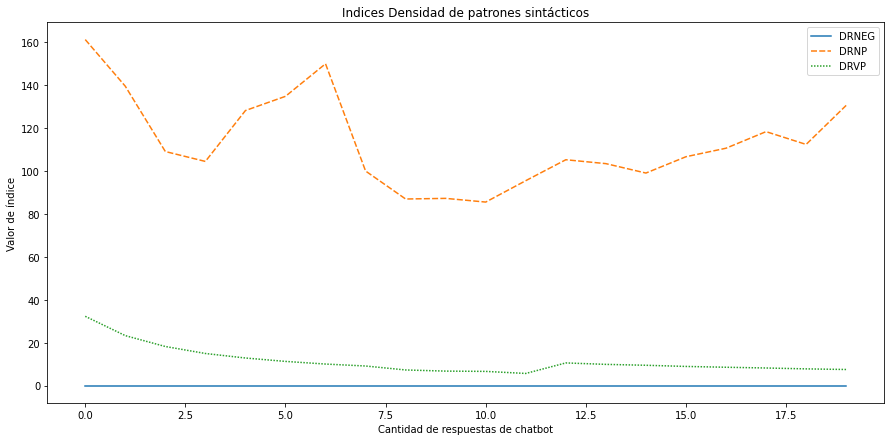

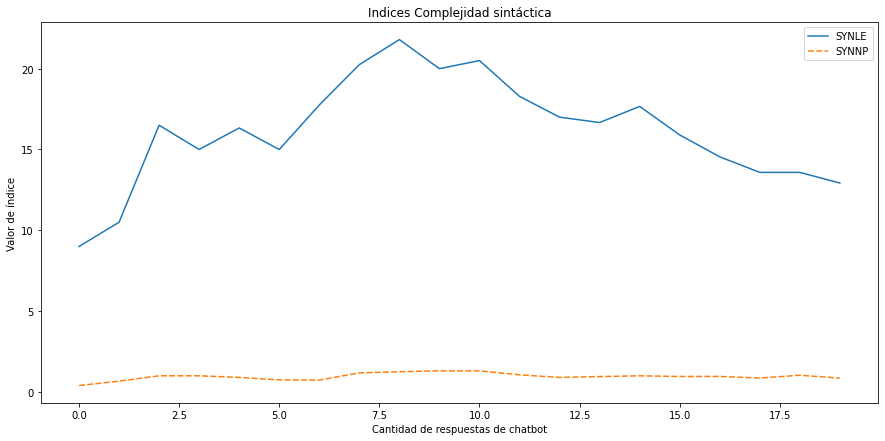

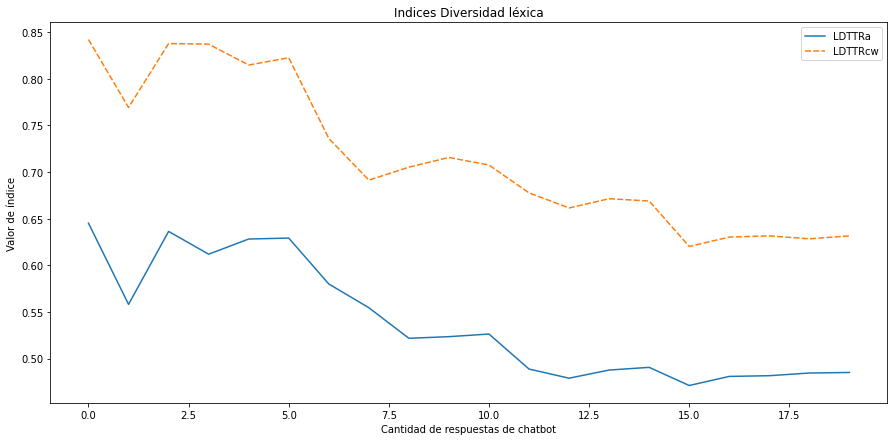

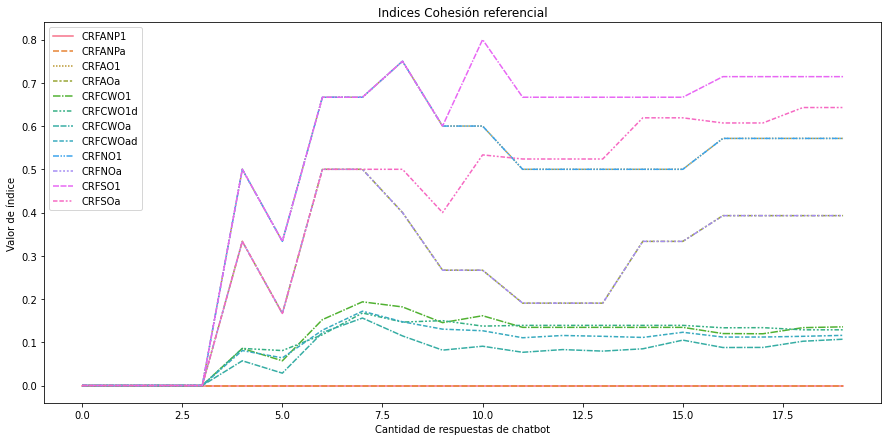

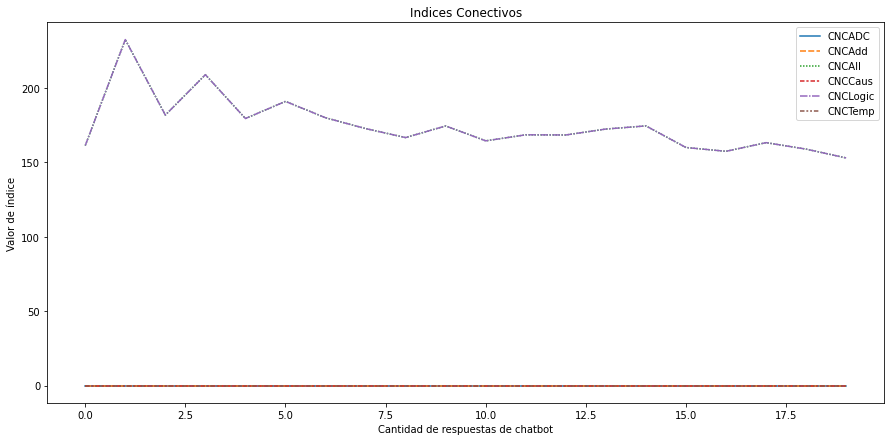

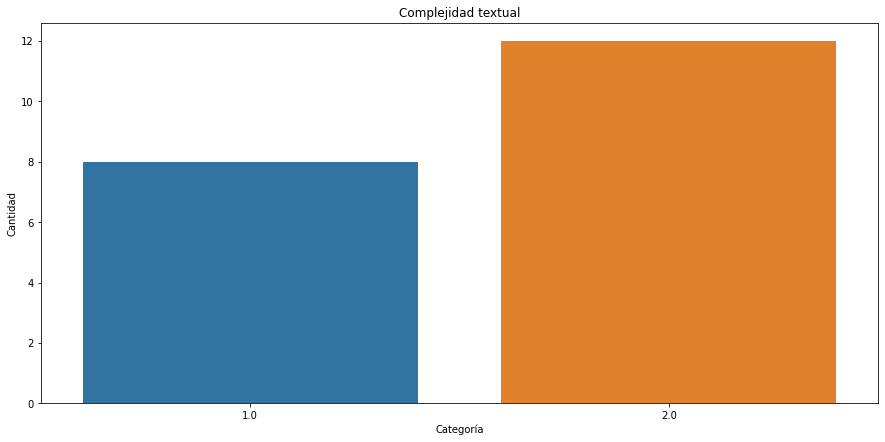

In [29]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \leq 1.5 \\
\ H_1 > 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [57]:
predicted_text_statistic_analysis_2(textual_complexity=1, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 0.88975652100261.
omg
Se rechaza la hipótesis nula. La media es 1.6
La moda 2.0 no es igual a la complejidad textual 1.
La exactitud de las predicciones es de 40.0%.


## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [75]:
losses = get_training_validation_perplexity(f'{BASE_DIRECTORY}/data/raw/log_grade_2_historia_150_epochs.txt', 150)
losses.describe()

,training,validation
count,150.000000,150.000000
mean,1153.732201,14700.003441
std,1684.745632,11076.844983
min,170.374678,3080.970735
25%,319.258143,5763.224152
50%,621.114301,10142.665627
75%,1410.524610,21233.589717
max,13534.537083,51379.780574


#### Curva de error: Capacidad de comprensión

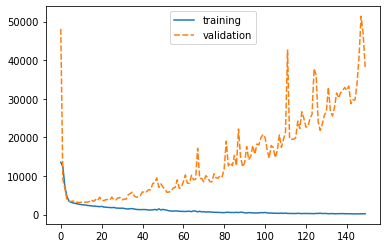

In [76]:
sns.lineplot(data=losses)
plt.show()

Al tener en cuenta la Figura y la media, se puede observar que el error es menor en el conjunto de prueba, lo que significa que el Chatbot es capaz de reconocer oraciones de entrada ya conocidos y, de manera similar, oraciones nuevas, como se observa en la curva de error del conjunto de validación. Sin embargo, se observa que la curva tiende al Overfitting debido a que el error en validación empieza a aumentar en las últimas épocas, lo que ocasionaría que el chatbot no responda con oraciones tan adecuadas. También, analizando la gráfica, se observa que el Chatbot aprende más rápido en el conjunto de entrenamiento que en el de validación. Ello también puede ser apreciado al analizar la desviación estándar, para dicha gráfica.

#### Obteniendo las respuestas del chatbot

In [77]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_historia_150_chat.txt')
print(chatbot_responses)

['proyección y comenzó', 'probable páginas y y y geographic dedicadas a a y y y y y a a y a a a', 'y y y y y y', 'belaúnde a y y y a a y y y y y y y y y y y a a a a a a a a a', 'y y y y y y', 'junio', 'belaúnde fernando y y y a a aprendizajes', 'personaje a a y y a y y y y y y y y y y y y y a a a a a a a y', 'y y y y y y', 'y y', 'belaúnde fernando y y y a a aprendizajes', 'personaje a a y y a y y y y y y y y y y y y a a a a a a a a a', 'y y y y y y', 'y', 'septiembre', 'y páginas y y y geographic dedicadas a a y y y y y a a y a a a', 'y y y y y y', 'belaúnde a y y y a a y y y y y y y y y y y a a a a a a a a a', 'y y y y y y', 'belaúnde a y y y a a y y y y y y y y y y y a a a a a a a a a']


#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [78]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 6.011979103088379 seconds.
Text analyzed in 5.881757020950317 seconds.
Text analyzed in 5.8459556102752686 seconds.
Text analyzed in 5.841963529586792 seconds.
Text analyzed in 5.894008159637451 seconds.
Text analyzed in 5.896097183227539 seconds.
Text analyzed in 5.875139236450195 seconds.
Text analyzed in 6.167445421218872 seconds.
Text analyzed in 5.946572542190552 seconds.
Text analyzed in 5.88143253326416 seconds.
Text analyzed in 5.963798522949219 seconds.
Text analyzed in 5.919432640075684 seconds.
Text analyzed in 5.949638605117798 seconds.
Text analyzed in 5.966244459152222 seconds.
Text analyzed in 5.9707324504852295 seconds.
Text analyzed in 5.932299852371216 seconds.
Text analyzed in 5.905580043792725 seconds.
Text analyzed in 5.94028115272522 seconds.
Text analyzed in 5.906656503677368 seconds.
Text analyzed in 5.929351091384888 seconds.
Text analyzed in 5.937880277633667 seconds.
Text analyzed in 5.984210968017578 seconds.
Text analyzed in 5.9348480701446

#### Graficando los índices y complejidad textual

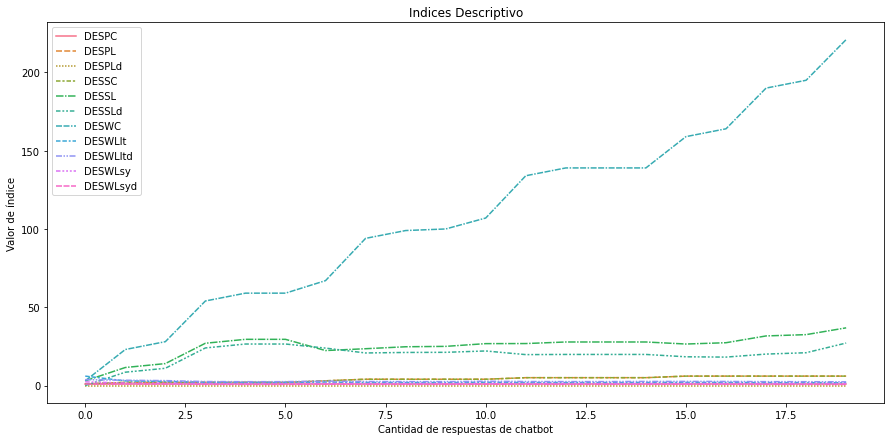

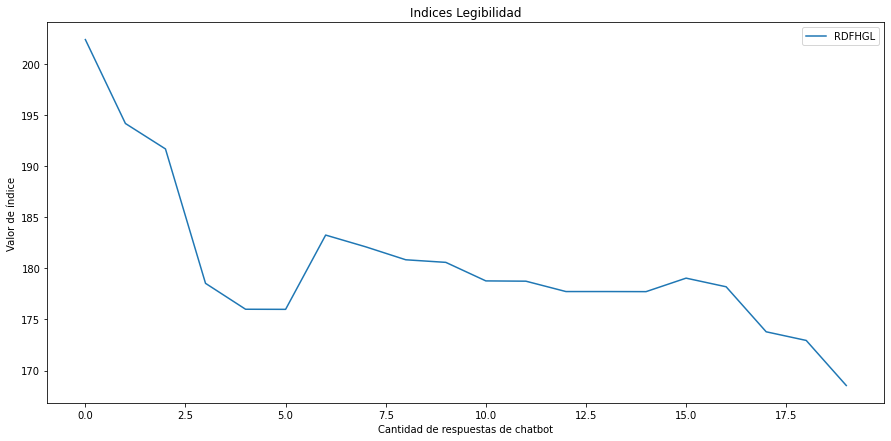

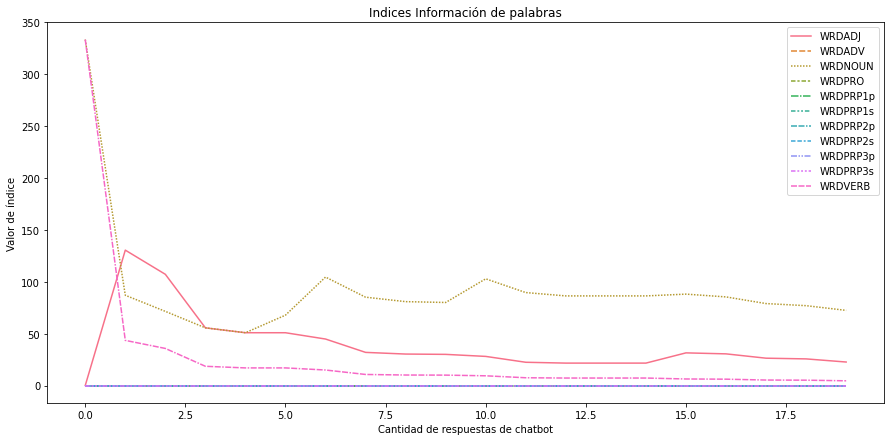

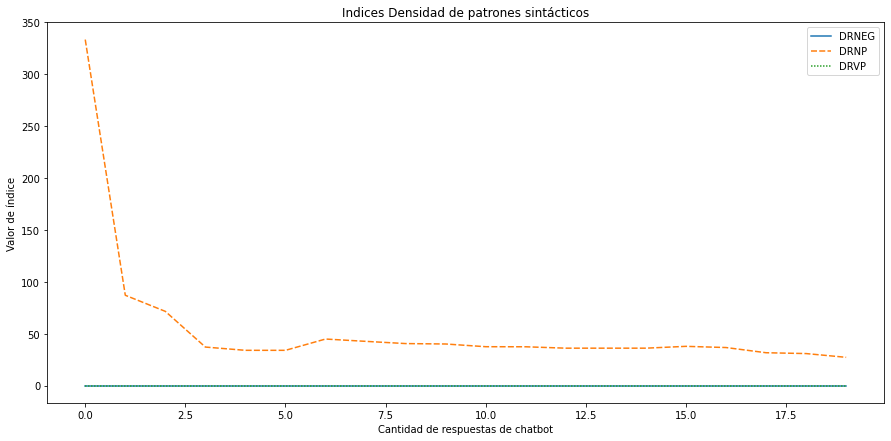

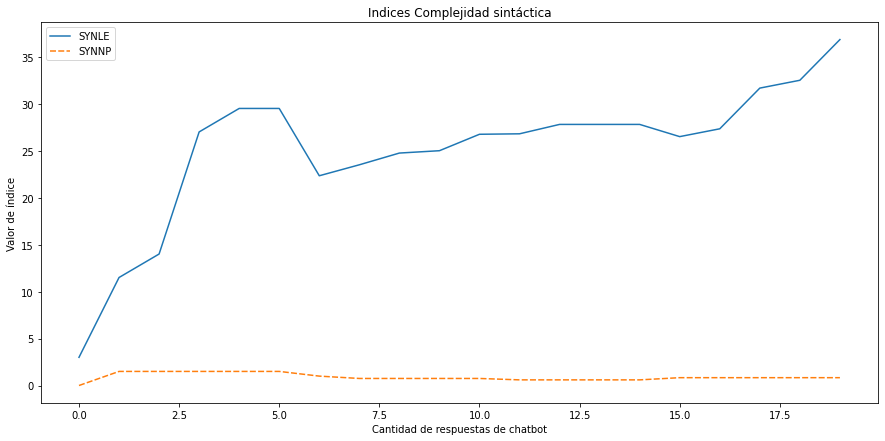

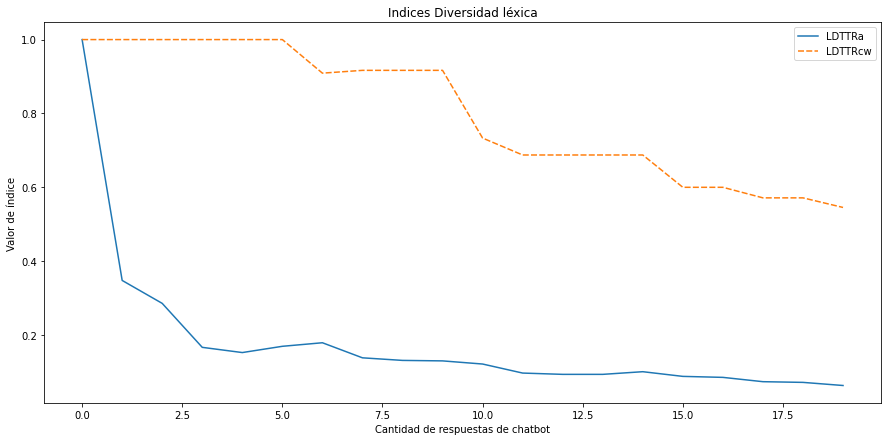

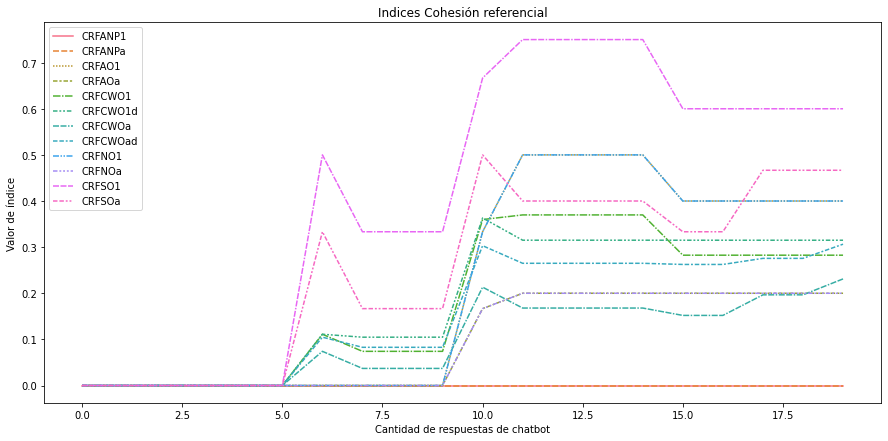

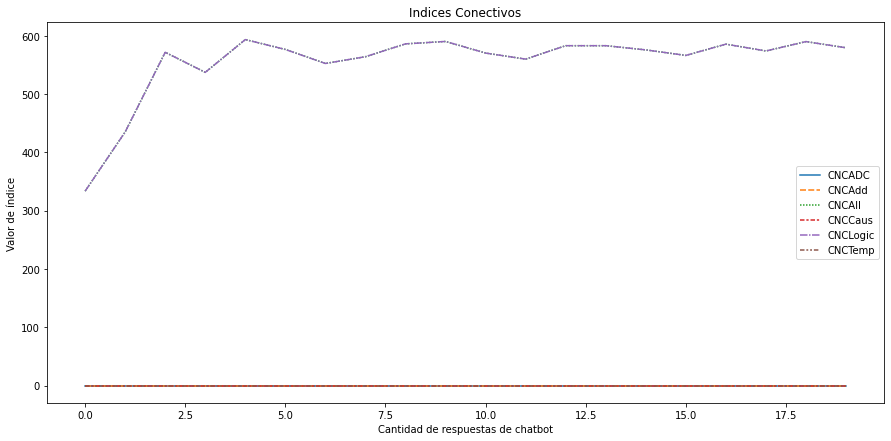

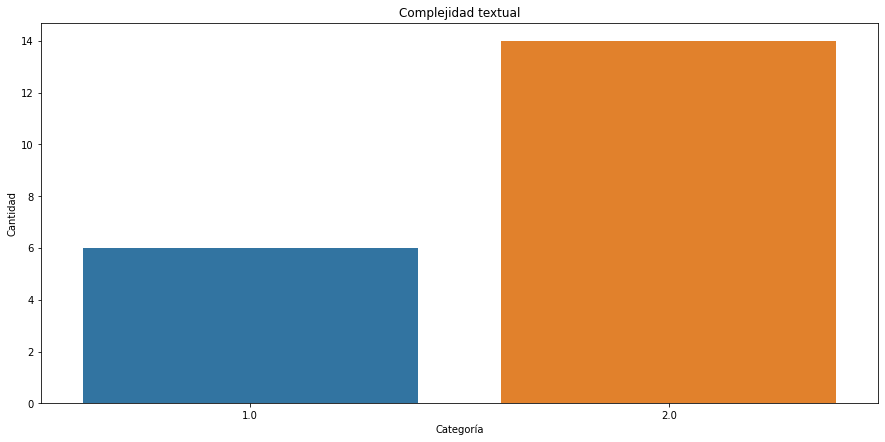

In [79]:
draw_indices(indices)

Para este tópico se diseña la siguiente hipótesis, en la cual se espera que la media de todas las predicciones de la complejidad textual de las respuestas sea menor igual a 1.5, ya que de ser así, significaría que las respuestas dadas son de complejidad 1.

\begin{align}
\ H_0 \geq 1.5 \\
\ H_1 < 1.5
\end{align}

Además, la moda debe concordar con el valor de complejidad textual esperado, el cual es 1 en este caso.

In [80]:
predicted_text_statistic_analysis_2(textual_complexity=2, predictions=indices['Complejidad textual'], mean=1.5, tail='lower', alpha=0.05)


El valor Z_0.95 es: 1.6448536269514722.
El valor Z_0 es 1.9023794624226835.
No hay suficientes pruebas para rechazar la hipótesis nula. La media es 1.7.
La moda 2.0 es igual a la complejidad textual 2.
La exactitud de las predicciones es de 70.0%.
